# Rapport de l'analyse portant sur la consommation du gaz d'un batiment 
Ce notebook constitue le rapport d’analyse du projet. Il présente l’exploration des données, la construction d’un modèle prédictif et l’interprétation des résultats, dans une approche claire et reproductible


**Compréhension du problème (Business Understanding)**

- Objectif : prédire la quantité de gaz consommée chaque mois.

- Enjeu métier : aider les ingénieurs en efficacité énergétique à optimiser la consommation d’énergie dans les bâtiments, en identifiant les périodes de forte consommation et les leviers possibles de réduction.

- Métriques utilisées : MAE, MSE et R², afin d’évaluer la précision globale du modèle et sa capacité à expliquer la variabilité de la consommation.

# Exploratory Data Analysis

---

1. Import packages
2. Loading data with Pandas
3. Analyse EDA et Visualisation
4. Modeling
6. Interpretation des prédictions
7. Limites et pISTES d'amélioration
8. Enregistrement du modèle

---

## 1. Import packages

In [8]:
import warnings
import numpy as np
import pandas as pd
from pickle import dump
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV, LassoCV
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

---

## 2. Loading data with Pandas

We need to load `data.csv` so we can work with it in Python

In [9]:
# df = pd.read_csv('data.csv')
df = pd.read_excel('../../data/data.xlsx')

---

## 3. Analyse EDA et Visualisation


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   code                  24 non-null     object        
 1   d_relevé              24 non-null     datetime64[ns]
 2   f_relevé              24 non-null     datetime64[ns]
 3   consommation_kwh_pcs  12 non-null     object        
 4   type_energie          24 non-null     object        
 5   adresse_compteur      24 non-null     object        
 6   code_postal           24 non-null     int64         
 7   dju                   24 non-null     float64       
 8   periode_reference     24 non-null     bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 1.6+ KB


Nous avons 24 observations dont 12 pour lesquelles il faut fournir des valeurs prédites.
Nous pouvons constaterdes Colonnes constantes (inutiles pour apprendre) : code, type_energie, adresse_compteur, code_postal (car elles ne varient jamais). Donc elles seront mises de côté.

Les Variables réellement utiles :

- ``dju`` (très fort signal “chauffage / saison”)

- ``temps`` : mois (ou encodage cyclique sin/cos du mois)

- ``nb_jours`` (durée de la période, Très faible variance mje ne vais pas l'inclure)

Notre variable cible est de type object avec des espaces -> transformation en numérique après suppression des espaces

In [11]:
# drop the constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=constant_columns, inplace=True)

In [12]:
# Transformation of consommation_kwh_pcs column
def clean_conso(series: pd.Series) -> pd.Series:
    """Conversion de '93 901' -> 93901 et maintien des NaN."""
    s = series.astype(str).str.replace(r"\s+", "", regex=True)
    s = s.replace("nan", np.nan)
    return pd.to_numeric(s, errors="coerce")

# add features
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Feature engineering on the dataframe."""
    df = df.copy()

    # Month cyclic encoding
    df["mois"] = df["d_relevé"].dt.month.astype(int)
    # la variable mois est cyclique, on utilise des transformations sin et cos pour capturer cette cyclicité
    df["mois_sin"] = np.sin(2 * np.pi * df["mois"] / 12.0)
    df["mois_cos"] = np.cos(2 * np.pi * df["mois"] / 12.0)

    return df

In [13]:
# Duration of the billing/reading period (monthly here)
df["nb_jours"] = (df["f_relevé"] - df["d_relevé"]).dt.days + 1
# clean consommation_kwh_pcs column
df["consommation_kwh_pcs"] = clean_conso(df["consommation_kwh_pcs"])
df = add_features(df)

In [14]:
df.describe()

,d_relevé,f_relevé,consommation_kwh_pcs,dju,nb_jours,mois,mois_sin,mois_cos
count,24,24,12.000000,24.000000,24.000000,24.000000,2.400000e+01,2.400000e+01
mean,2021-12-15 22:00:00,2022-01-14 08:00:00,39731.166667,216.963750,30.416667,6.500000,-1.435455e-17,-4.466148e-17
min,2019-01-01 00:00:00,2019-01-31 00:00:00,5924.000000,6.000000,28.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,2019-06-23 12:00:00,2019-07-23 06:00:00,7483.750000,41.475000,30.000000,3.750000,-5.915064e-01,-5.915064e-01
50%,2021-12-16 00:00:00,2022-01-15 00:00:00,41987.500000,218.000000,31.000000,6.500000,-6.123234e-17,-6.123234e-17
75%,2024-06-08 12:00:00,2024-07-07 18:00:00,57960.750000,344.050000,31.000000,9.250000,5.915064e-01,5.915064e-01
max,2024-12-01 00:00:00,2024-12-31 00:00:00,93901.000000,470.000000,31.000000,12.000000,1.000000e+00,1.000000e+00
std,NaN,NaN,31493.545985,160.220381,0.880547,3.526299,7.223151e-01,7.223151e-01


La variable nb_jours a une variance très faible, par conséquent, elle ne sera pas inclu dans l'analyse.

In [15]:
df.drop(columns=["nb_jours"], inplace=True)

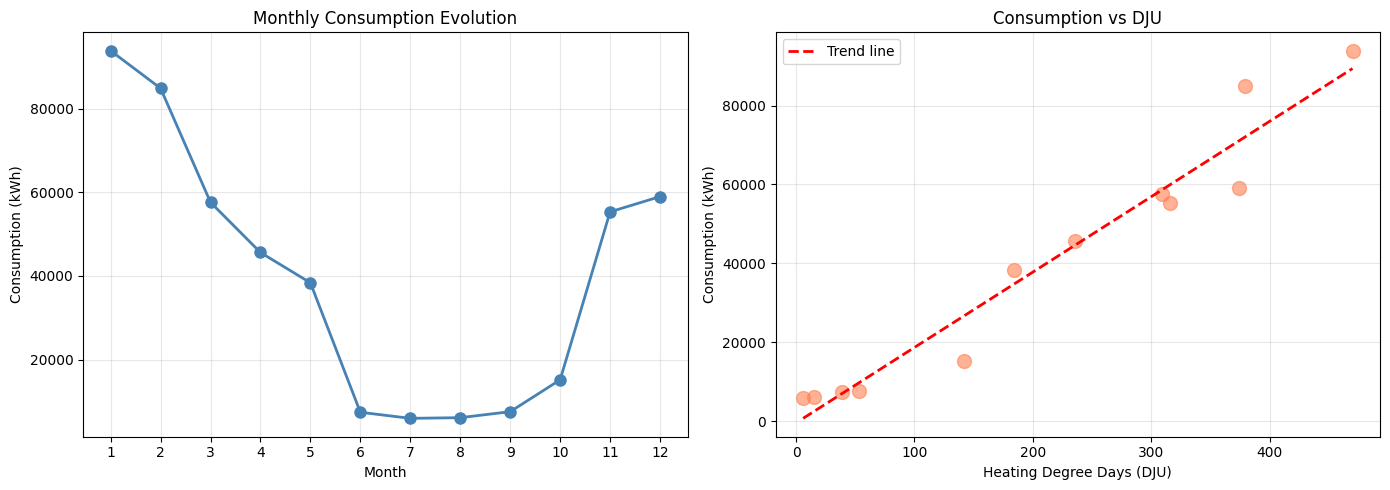

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 1. Monthly consumption evolution
ax[0].plot(df['mois'], df['consommation_kwh_pcs'], marker='o', linewidth=2, markersize=8, color='steelblue')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Monthly Consumption Evolution')
ax[0].set_xticks(range(1, 13))
ax[0].grid(True, alpha=0.3)

# 2. Consumption evolution vs DJU
ax[1].scatter(df['dju'], df['consommation_kwh_pcs'], alpha=0.6, s=100, color='coral')

# add trend line
z = df[df["periode_reference"]==True]
p = np.poly1d(np.polyfit(z['dju'], z['consommation_kwh_pcs'], 1))
ax[1].plot(z['dju'].sort_values(), p(z['dju'].sort_values()), "r--", linewidth=2, label='Trend line')
ax[1].set_xlabel('Heating Degree Days (DJU)')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_title('Consumption vs DJU')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Observations principales :**

1. **Saisonnalité très marquée** : consommation élevée en période froide (chauffage)
   - La consommation suit clairement les saisons et la température
   - La plus basse consommation est en été (pas de besoin de chauffage)
   - Pic en hiver (janvier-février) : ~85,000-90,000 kWh

2. **Relation DJU-Consommation** :
   - Relation fortement positive et linéaire entre DJU et consommation
   - Le DJU est un excellent prédicteur de la consommation de gaz
   - Causalité claire: plus il fait froid (DJU élevé), plus on consomme de gaz pour le chauffage
   - C'est une relation stable et fiable pour modéliser la consommation

**Conclusion EDA :**
- Les données présentent une structure claire et prévisible
- Les variables sélectionnées (DJU, mois_sin, mois_cos) sont pertinentes
- Un modèle simple devrait donner de bonnes performances

Text(0.5, 1.0, 'Correlation Matrix')

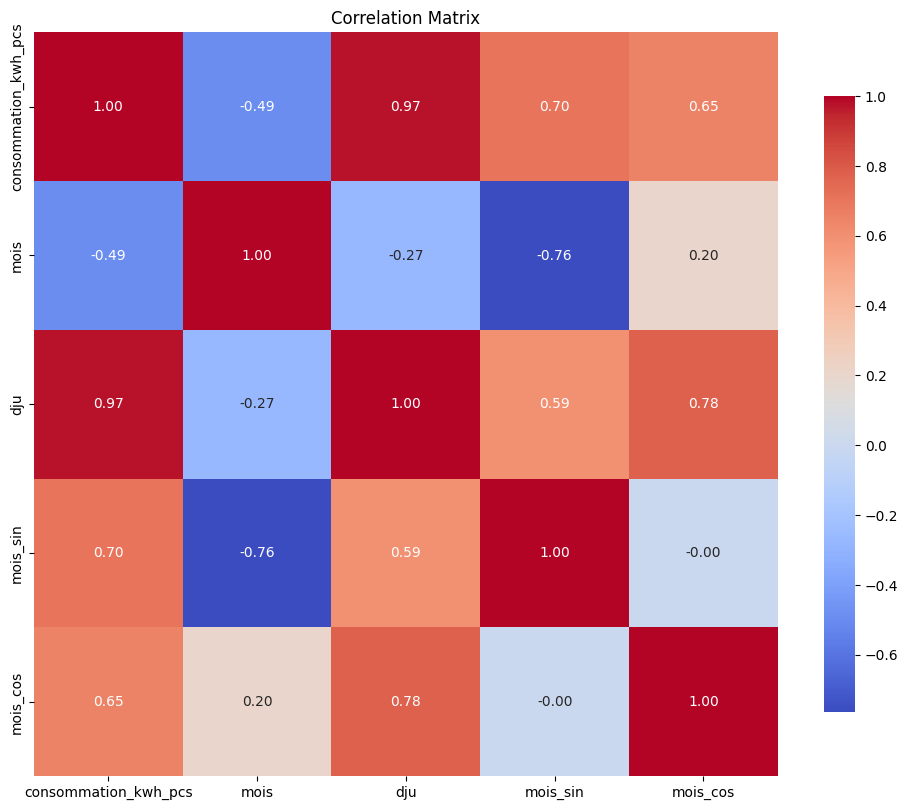

In [17]:
# Correlation matrix with useful features
import seaborn as sns
corr = df[["consommation_kwh_pcs", "mois","dju","mois_sin", "mois_cos"]].corr()  
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

On obeserve une corrélation très forte entre dju et la consommation (≈ 0,97 sur tes 12 points d’apprentissage) : c’est tout à fait cohérent avec un bâtiment chauffé. D'ailleurs, cela confirme le graphe établi précedemment sur l'évolution de la consommation de gaz par rapport au dju et égalment la pertinece des variables dju, mois_sin, mois_cos comme des facteurs déterministes

---

## 4. Modeling - Simple Regression models with 3 Variables

Ici, je construis un modèle de régression afin de prédire la consommation. L’objectif est d’évaluer rapidement la performance plutôt que d’optimiser au maximum

Dans ce contexte d’ingénierie énergétique, la MAE sera ma métrique principale car elle est interprétable directement en kWh (erreur typique mensuelle). La RMSE complète l’analyse car elle pénalise davantage les erreurs importantes, notamment en période froide où les enjeux de chauffage sont plus critiques. Le R² est rapporté à titre indicatif pour apprécier la part de variabilité expliquée, mais il est interprété avec prudence compte tenu du faible effectif. 
Enfin, je vérifie le biais moyen afin d’éviter un modèle systématiquement sur/sous-estimateur.

Nous allons modéliser les données avec une régression linéaire RidgeCV (qui ajustent automatiquement les hyperparamètres) et ne validation croisée temporelle afin d’éviter toute fuite de données pendant l’entraînement. Dans ce cas précis, je privilégie Ridge plutôt que Lasso, car Ridge pénalise moins fortement les coefficients et nous n’avons que trois variables explicatives

Je veux conserver tous les prédicteurs (Ridge rétrécit mais ne met pas à zéro).
Je juge que ces trois variables sont toutes utiles.

La quantité de données disponible m’oblige à tout utiliser pour l’entraînement, même si ce n’est pas recommandé d’un point de vue pédagogique.



In [18]:
# Prepare data: select only the rows to use for modeling and sort chronologically
data_train = df[df['periode_reference'] == True].copy()
data_train = data_train.sort_values('d_relevé').reset_index(drop=True)

# Features and target
X = data_train[['dju','mois_sin','mois_cos']].copy()
y = data_train['consommation_kwh_pcs'].copy()

# Spplinting data
idx_split = int(0.8 * len(data_train))
X_train, X_test = X.iloc[:idx_split], X.iloc[idx_split:]
y_train, y_test = y.iloc[:idx_split], y.iloc[idx_split:]

tscv = TimeSeriesSplit(n_splits=3)

In [19]:
def train_tuning_select(X_train, y_train , X_test, y_test, tscv, metric="neg_mean_absolute_error"):

    print(f"\n{'='*80}")
    print(f"FINE-TUNING (Metric: MAE) FOR RIDGE REGRESSION")
    print(f"{'='*80}")
    metrics_results = []
    # ridge model
    ridgecv = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(scoring=metric,cv=tscv)),
    ])
    ridgecv.fit(X_train, y_train)

    # Summary table
    print("\n\n" + "="*80)
    print("BEST ALPHA - METRICS FOR RIDGE REGRESSION")
    print("="*80)

    # Select best alpha based on MAE
    best_alpha = ridgecv.named_steps['model'].alpha_
    best_mae = -ridgecv.named_steps["model"].best_score_ 
    print(f"\n✓ Best alpha for Ridge: {ridgecv.named_steps['model'].alpha_} with an mae of {best_mae:.2f}")

    print(f"\n\n{'='*80}")
    print(f"✓ BEST RIDGE IS : RIDGE WITH ALPHA = {best_alpha}")
    print(f"{'='*80}")

    y_pred = ridgecv.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    metrics_results.append({
        "model": "RidgeCV",
        "alpha": best_alpha,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    print(f"\n✓ Ridge Regression - Metrics on Test data(Never Seen data): ")
    print(f"   - RMSE: {rmse:.4f}")
    print(f"   - MAE: {mae:.4f}")
    print(f"   - R2: {r2:.4f}")
    return ridgecv, metrics_results


In [20]:
best_estimator = train_tuning_select(X_train, y_train, X_test, y_test, tscv)[0]


FINE-TUNING (Metric: MAE) FOR RIDGE REGRESSION


BEST ALPHA - METRICS FOR RIDGE REGRESSION

✓ Best alpha for Ridge: 0.1 with an mae of 15451.49


✓ BEST RIDGE IS : RIDGE WITH ALPHA = 0.1

✓ Ridge Regression - Metrics on Test data(Never Seen data): 
   - RMSE: 14320.7979
   - MAE: 13750.8227
   - R2: 0.4803


## 5. Interprétation des Résultats de Modélisation

**Approche**
Modèle linéaire RidgeCV (standardisation incluse), sélection d’alpha par validation croisée temporelle pour éviter la fuite de données.

Sélection du meilleur modèle sur la métrique MAE.
Métriques suivies
- R² : part de variance expliquée.
- MAE : erreur absolue moyenne (en kWh).
- RMSE : erreur quadratique moyenne et sa racine.

**Résultats**
- Alpha optimal : 0.1, MAE CV ~ 15 451.
- Test (données jamais vues) : RMSE 14 321, MAE 13 751, R² 0.48.
- Le Ridge (alpha=0.1) est le meilleur selon le MAE CV.

**Interprétation**
- Performances modestes (R² ~0.48) : le modèle capte une partie de la variance mais laisse beaucoup d’erreur résiduelle, probablement faute de données (12 observations).
- Erreurs absolues (MAE ~13–15k) restent élevées : incertitude notable sur les prédictions.


---
## 6. Analyse et Interpretation des features

In [ ]:
def linear_feature_importance(estimator, feature_names):
    """
    fitted_pipeline : Pipeline(scaler, model) pour Ridge/Lasso
    feature_names   : liste des colonnes X
    """
    coefs = estimator['model'].coef_
    imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    }).sort_values("abs_coef", ascending=False)
    return imp

# Exemple:
features_cols = ['dju', 'mois_sin', 'mois_cos']
imp_df = linear_feature_importance(best_estimator, features_cols)
display(imp_df)


,feature,coef,abs_coef
0,dju,26418.055254,26418.055254
2,mois_cos,3871.265828,3871.265828
1,mois_sin,3491.779177,3491.779177


La dominance du DJU est importante avec un impact total de ~78%. DJU ressort comme feature n°1, ce qui est cohérent avec un bâtiment chauffé.

L'effet saison est non négligeable avec une importance de ~22%.

Les termes de saisonalité mois_sin, mois_cos capturent les variations cycliques non expliquées par la DJU. Ils ont un impact non néglageble car le DJU explique déjà ~78% → peu de room pour la saisonnalité pure.

In [ ]:
def compute_bias(y_true, y_pred):
    """
    Mean Bias Error (MBE)
    > 0 : sur-estimation
    < 0 : sous-estimation
    """
    return 100 * np.sum(y_pred - y_true) / np.sum(y_true), float(np.mean(y_pred - y_true))

biais_rela, biais = compute_bias(y_test, best_estimator.predict(X_test))
print(f"\nBiais relatif: {biais_rela:.2f} %")
print(f"\nBiais moyen: {biais:.2f} kWh")


Biais relatif: 31.86 %

Biais moyen: 13750.82 kWh


L’analyse du biais montre une sur-estimation moyenne de 13750 kWh, soit +31,863 % de la consommation réelle.
Ce biais, bien que non nul, reste presqu'inacceptable dans un contexte d’ingénierie énergétique exploratoire.

Ce biais s’explique probablement par la faible taille de l’échantillon et l’absence de variables supplémentaires, qui limitent la capacité du modèle à ajuster finement la consommation réelle.

---

## 7. Limites du modèle et Pistes d'amélioration

**Limites**

- Le modèle est entraîné sur un faible volume de données (12 observations), ce qui limite la robustesse des métriques et la généralisation.

- Peu de diversité de variables explicatives : on n’a pas d’informations sur l’occupation réelle, les surfaces. Le modèle explique bien la saisonnalité mais peut manquer des ruptures d’usage. J'aurais pu ajouter des variables météorologiques et calendaires mais mais le nombre d'observations ne me permettait pas d'inclure ces dernières.

- Granularité mensuelle : l’agrégation masque les effets court terme (vacances, absences, pics) et limite la détection d’anomalies fines.

**Pistes d’amélioration**

- Disposer d’un historique plus long pour améliorer l’apprentissage et la stabilité des métriques.

- Ajouter des features métier : occupation (taux, horaires), jours ouvrés / vacances, température moyenne, surface, usage (bureau/école), humidté, duration d'ensollellment.

Tester des modèles adaptés pour quantifier l'incertitude autour de la conommation:

quantile regression pour donner des intervalles.
